# Comprehensive Airline Delay Analysis Report


### Overview
This report explores airline delays from 2003 to 2024, focusing on:
1. Yearly trends in flights, delays, and cancellations.
2. Analysis of delay reasons over time.
3. Performance of carriers and airports.
4. Comparative trends for major hubs/carriers vs. the overall dataset.
    

In [1]:
import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import numpy as np

# Initialize AWS Session
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()

# Use SageMaker's default bucket
bucket = sagemaker_session.default_bucket()

# Set up Athena connection with the default bucket
s3_staging_dir = f's3://{bucket}/athena-query-results/'
conn = connect(s3_staging_dir=s3_staging_dir, region_name=region)

# Query Athena for the filtered dataset
query = "SELECT * FROM db_airline_delay_cause.airline_delay_cause_csv_raw"

print("Querying Athena...")

try:
    airline_data = pd.read_sql(query, conn)
    print("Data loaded successfully!")
    print(f"Number of rows: {len(airline_data)}")
except Exception as e:
    print(f"Failed to execute Athena query: {e}")

# Clean the data
cleaned_data = airline_data.fillna(0)  # Fill missing values
cleaned_data['delay_rate'] = (cleaned_data['arr_del15'] / cleaned_data['arr_flights']).fillna(0) * 100


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Querying Athena...


/tmp/ipykernel_134/2370543800.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  airline_data = pd.read_sql(query, conn)


Data loaded successfully!
Number of rows: 390637


## Yearly Trends: Flights, Delays, and Cancellations

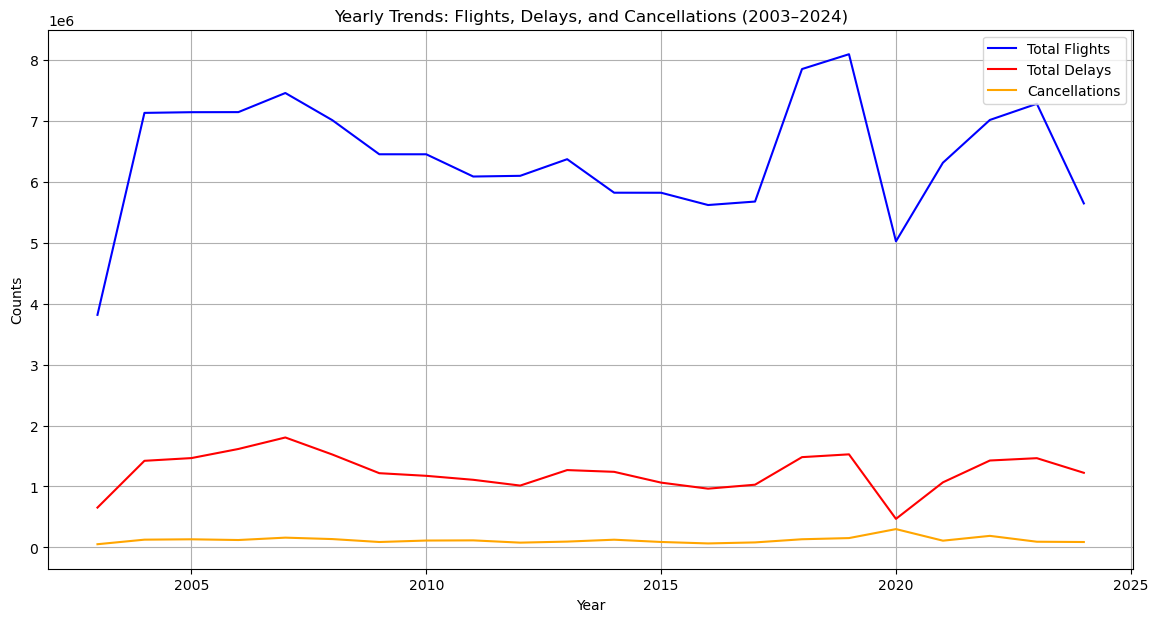

In [2]:
import matplotlib.pyplot as plt

# Calculate yearly totals for flights, delays, and cancellations
yearly_summary = cleaned_data.groupby('year')[
    ['arr_flights', 'arr_del15', 'arr_cancelled']
].sum().reset_index()
yearly_summary['overall_delay_rate'] = (yearly_summary['arr_del15'] / yearly_summary['arr_flights']).fillna(0) * 100

# Plot yearly trends
plt.figure(figsize=(14, 7))
plt.plot(yearly_summary['year'], yearly_summary['arr_flights'], label='Total Flights', color='blue')
plt.plot(yearly_summary['year'], yearly_summary['arr_del15'], label='Total Delays', color='red')
plt.plot(yearly_summary['year'], yearly_summary['arr_cancelled'], label='Cancellations', color='orange')
plt.title('Yearly Trends: Flights, Delays, and Cancellations (2003–2024)')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()
    

## Delay Reasons Analysis

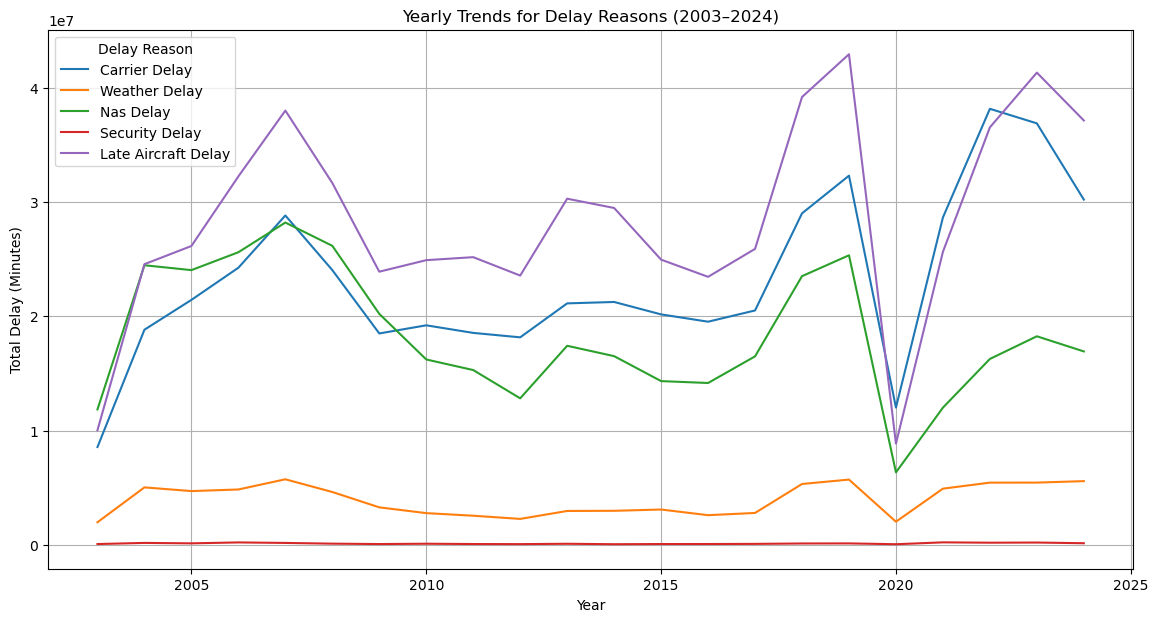

In [3]:
# Analyze yearly totals for delay reasons
delay_reasons = cleaned_data.groupby('year')[
    ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
].sum().reset_index()

# Plot trends for delay reasons
plt.figure(figsize=(14, 7))
for column in delay_reasons.columns[1:]:
    plt.plot(delay_reasons['year'], delay_reasons[column], label=column.replace('_', ' ').title())
plt.title('Yearly Trends for Delay Reasons (2003–2024)')
plt.xlabel('Year')
plt.ylabel('Total Delay (Minutes)')
plt.legend(title='Delay Reason')
plt.grid()
plt.show()
    

## Carrier Performance Analysis

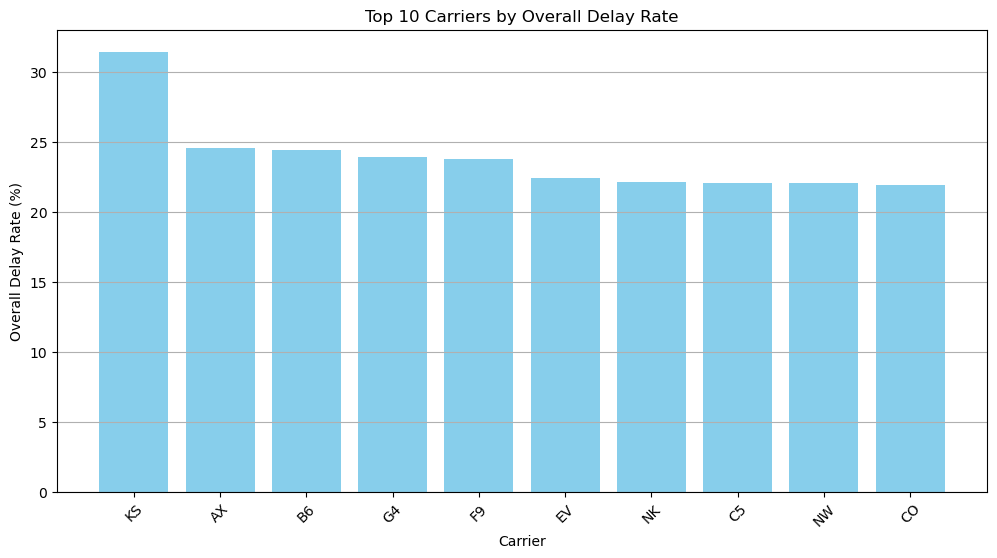

In [4]:
# Calculate delay rates by carrier
carrier_performance = cleaned_data.groupby('carrier')[
    ['arr_flights', 'arr_del15', 'carrier_delay', 'weather_delay', 'nas_delay', 'late_aircraft_delay']
].sum().reset_index()
carrier_performance['overall_delay_rate'] = (carrier_performance['arr_del15'] / carrier_performance['arr_flights']).fillna(0) * 100

# Plot top carriers by delay rate
top_carriers = carrier_performance.sort_values('overall_delay_rate', ascending=False).head(10)
plt.figure(figsize=(12, 6))
plt.bar(top_carriers['carrier'], top_carriers['overall_delay_rate'], color='skyblue')
plt.title('Top 10 Carriers by Overall Delay Rate')
plt.xlabel('Carrier')
plt.ylabel('Overall Delay Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
    

## Airport Performance Analysis

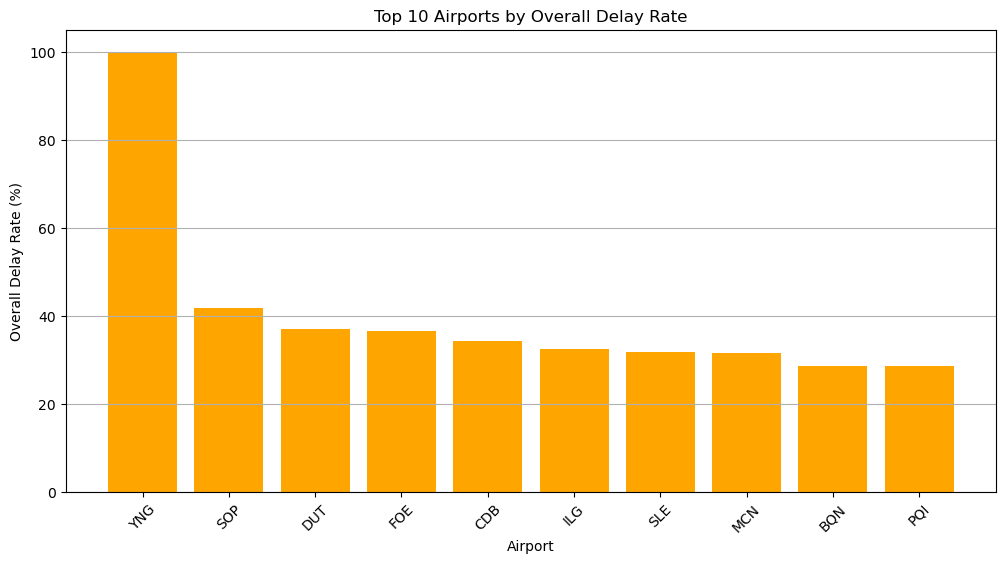

In [5]:
# Analyze airport performance
airport_performance = cleaned_data.groupby('airport')[
    ['arr_flights', 'arr_del15', 'arr_cancelled', 'arr_diverted']
].sum().reset_index()
airport_performance['overall_delay_rate'] = (airport_performance['arr_del15'] / airport_performance['arr_flights']).fillna(0) * 100

# Plot top delay-prone airports
top_airports = airport_performance.sort_values('overall_delay_rate', ascending=False).head(10)
plt.figure(figsize=(12, 6))
plt.bar(top_airports['airport'], top_airports['overall_delay_rate'], color='orange')
plt.title('Top 10 Airports by Overall Delay Rate')
plt.xlabel('Airport')
plt.ylabel('Overall Delay Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
    

## Comparison: Total Flights vs. Total Delays

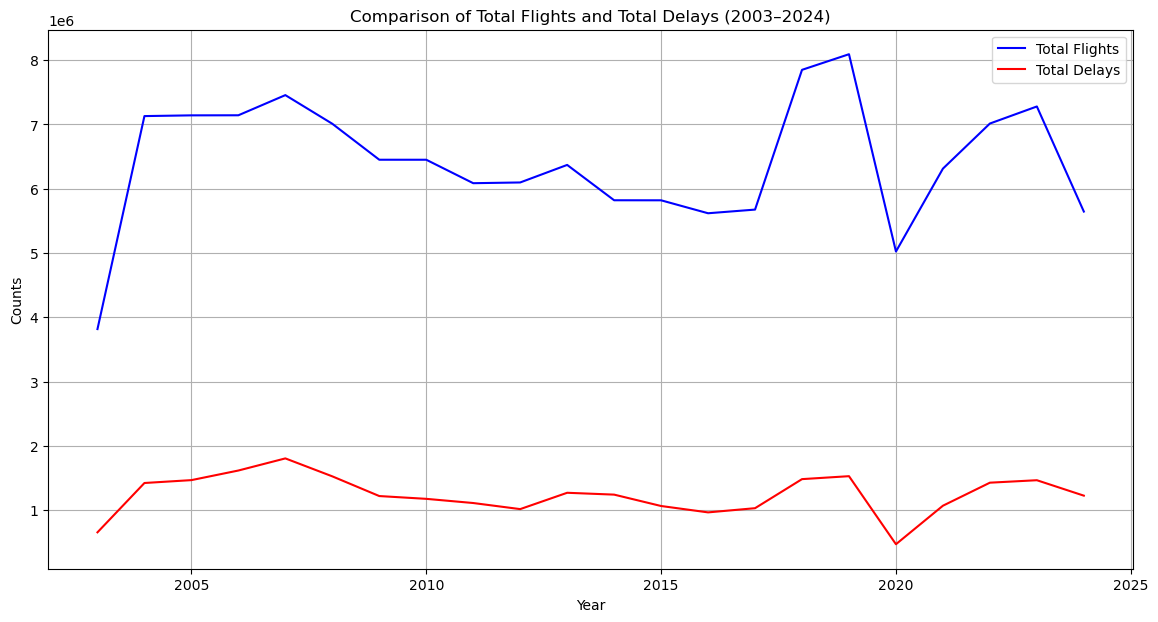

In [6]:
# Calculate yearly totals for flights and delays
yearly_flights_delays = cleaned_data.groupby('year')[
    ['arr_flights', 'arr_del15']
].sum().reset_index()

# Plot total flights vs total delays
plt.figure(figsize=(14, 7))
plt.plot(yearly_flights_delays['year'], yearly_flights_delays['arr_flights'], label='Total Flights', color='blue')
plt.plot(yearly_flights_delays['year'], yearly_flights_delays['arr_del15'], label='Total Delays', color='red')
plt.title('Comparison of Total Flights and Total Delays (2003–2024)')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()
    

## Comparison: Major Hubs/Carriers vs. Overall Trends

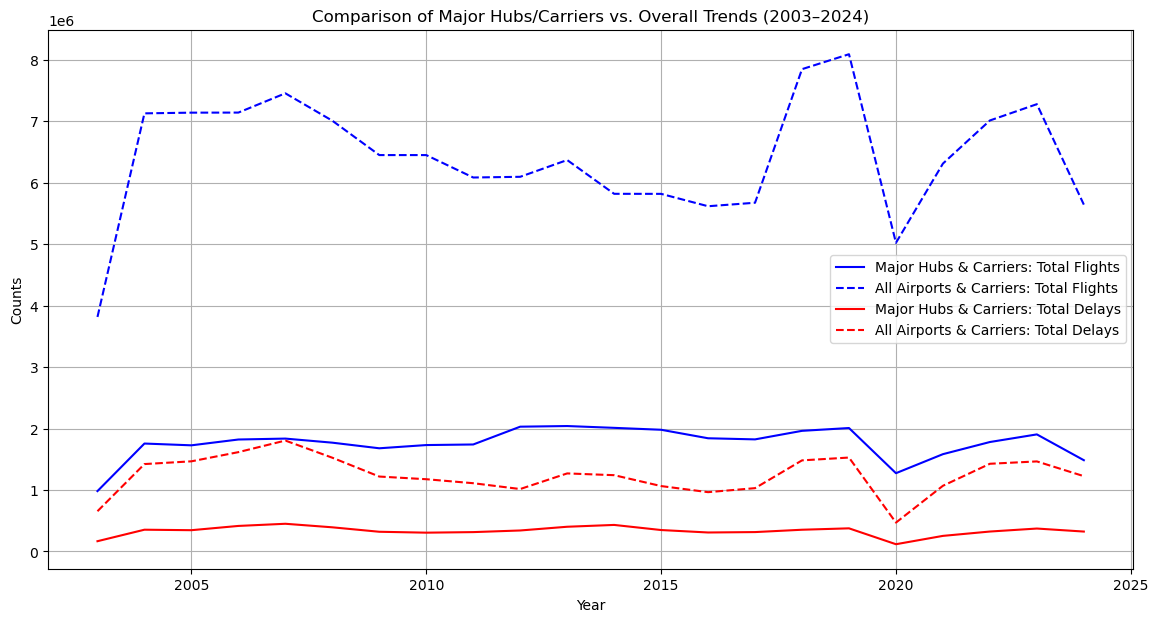

In [7]:
# Identify top carriers and airports
top_carriers = cleaned_data.groupby('carrier')['arr_flights'].sum().sort_values(ascending=False).head(10).index.tolist()
top_airports = cleaned_data.groupby('airport')['arr_flights'].sum().sort_values(ascending=False).head(10).index.tolist()

# Filter for major carriers and airports
major_data = cleaned_data[
    (cleaned_data['carrier'].isin(top_carriers)) & (cleaned_data['airport'].isin(top_airports))
]
major_summary = major_data.groupby('year')[['arr_flights', 'arr_del15']].sum().reset_index()

# Calculate delay rates for major hubs and overall dataset
overall_summary = cleaned_data.groupby('year')[['arr_flights', 'arr_del15']].sum().reset_index()
plt.figure(figsize=(14, 7))
plt.plot(major_summary['year'], major_summary['arr_flights'], label='Major Hubs & Carriers: Total Flights', color='blue')
plt.plot(overall_summary['year'], overall_summary['arr_flights'], label='All Airports & Carriers: Total Flights', color='blue', linestyle='--')
plt.plot(major_summary['year'], major_summary['arr_del15'], label='Major Hubs & Carriers: Total Delays', color='red')
plt.plot(overall_summary['year'], overall_summary['arr_del15'], label='All Airports & Carriers: Total Delays', color='red', linestyle='--')
plt.title('Comparison of Major Hubs/Carriers vs. Overall Trends (2003–2024)')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()
    

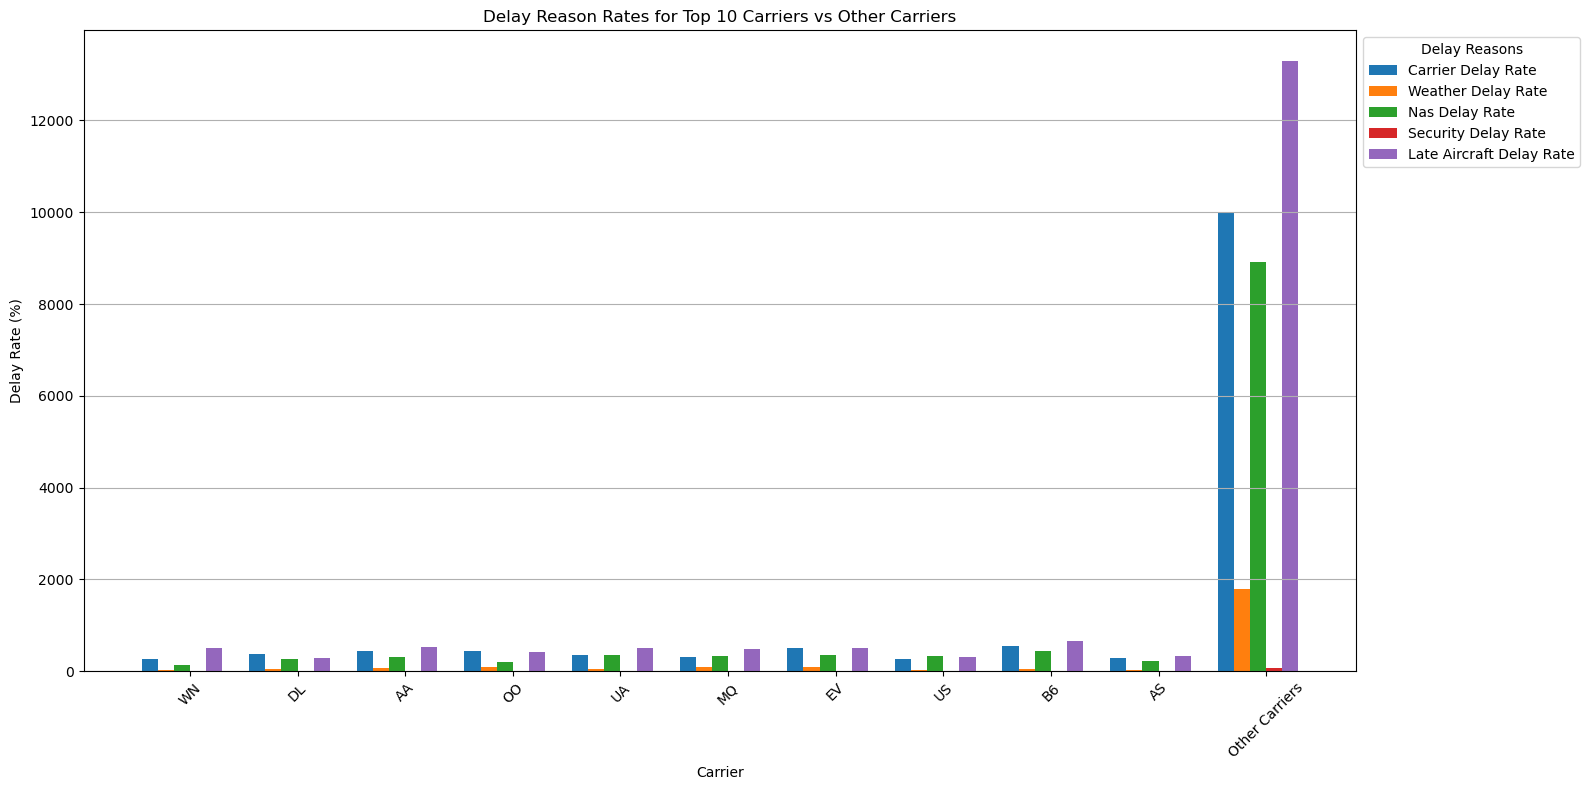

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure arr_flights has no zero values to prevent division errors
cleaned_data = cleaned_data[cleaned_data['arr_flights'] > 0]

# Calculate delay reason rates for each carrier
carrier_delay_reasons = cleaned_data.groupby('carrier')[
    ['arr_flights', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
].sum().reset_index()

# Add delay reason rates as percentages of total flights
for reason in ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']:
    carrier_delay_reasons[f'{reason}_rate'] = (carrier_delay_reasons[reason] / carrier_delay_reasons['arr_flights']).fillna(0) * 100

# Identify the top 10 carriers by total flights
top_10_carriers = carrier_delay_reasons.nlargest(10, 'arr_flights')

# Aggregate "Other Carriers"
other_carriers = carrier_delay_reasons[~carrier_delay_reasons['carrier'].isin(top_10_carriers['carrier'])]
other_carriers_summary = other_carriers.sum(numeric_only=True).to_frame().T
other_carriers_summary['carrier'] = 'Other Carriers'

# Combine top 10 and "Other Carriers"
combined_data = pd.concat([top_10_carriers, other_carriers_summary], ignore_index=True)

# Fill missing values to avoid plotting issues
reasons = ['carrier_delay_rate', 'weather_delay_rate', 'nas_delay_rate', 'security_delay_rate', 'late_aircraft_delay_rate']
combined_data[reasons] = combined_data[reasons].fillna(0)

# Plot delay reason rates for top 10 carriers and others
x = np.arange(len(combined_data))  # Number of carriers (top 10 + 'Other Carriers')
width = 0.15  # Bar width

# Create figure
plt.figure(figsize=(16, 8))

# Plot each delay reason
for i, reason in enumerate(reasons):
    plt.bar(x + i * width, combined_data[reason], width, label=reason.replace('_', ' ').title())

# Labeling
plt.xticks(x + width * (len(reasons) / 2), combined_data['carrier'], rotation=45)
plt.title('Delay Reason Rates for Top 10 Carriers vs Other Carriers')
plt.ylabel('Delay Rate (%)')
plt.xlabel('Carrier')
plt.legend(title='Delay Reasons', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Feature Engineering

In [9]:
# Feature Engineering: Create binary column for on-time or not on-time
def is_on_time(row):
    if row['arr_del15'] > 0 or row['arr_cancelled'] > 0:
        return 0  # Not On-Time
    else:
        return 1  # On-Time

# Apply the function to create a new column 'on_time'
cleaned_data['on_time'] = cleaned_data.apply(is_on_time, axis=1)

# Verify the binary column creation
print(cleaned_data['on_time'].value_counts())

# Check the dataset with the new column
cleaned_data.head()

on_time
0    379217
1     10766
Name: count, dtype: int64


,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,delay_rate,on_time
0,2024,9,9E,ABE,81.0,7.0,5.61,0.56,0.84,0.0,...,0.0,0.0,243.0,201.0,15.0,27.0,0.0,0.0,8.641975,0
1,2024,9,9E,AEX,81.0,6.0,4.43,0.00,1.13,0.0,...,0.0,0.0,647.0,440.0,0.0,189.0,0.0,18.0,7.407407,0
2,2024,9,9E,AGS,133.0,12.0,3.49,2.04,3.84,0.0,...,10.0,0.0,2382.0,1269.0,594.0,167.0,0.0,352.0,9.022556,0
3,2024,9,9E,ALB,73.0,4.0,0.82,1.00,0.23,0.0,...,0.0,0.0,160.0,28.0,15.0,9.0,0.0,108.0,5.479452,0
4,2024,9,9E,ATL,2204.0,280.0,61.70,17.36,88.36,0.0,...,40.0,4.0,24383.0,7840.0,2297.0,3690.0,0.0,10556.0,12.704174,0


# Split into 60/40 Dev/Prod Data Temporally

In [10]:
cleaned_data.columns

Index(['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'delay_rate', 'on_time'],
      dtype='object')

In [11]:
# Ensure the dataset is sorted by year and month
cleaned_data = cleaned_data.sort_values(by=['year', 'month'])

# Split data into Development (2004-2015) and Production (2016-2024)
dev_data = cleaned_data[(cleaned_data['year'] >= 2004) & (cleaned_data['year'] <= 2015)]
prod_data = cleaned_data[(cleaned_data['year'] >= 2016) & (cleaned_data['year'] <= 2024)]

# Print split summary
print(f"Development Data: {dev_data.shape[0]} rows")
print(f"Production Data: {prod_data.shape[0]} rows")

# Show sample data
dev_data.head(), prod_data.head()


Development Data: 198829 rows
Production Data: 182397 rows


(        year  month carrier airport  arr_flights  arr_del15  carrier_ct  \
 380481  2004      1      DL     PBI        650.0      126.0       21.06   
 380482  2004      1      DL     PDX        314.0       61.0       14.09   
 380483  2004      1      DL     PHL        513.0       97.0       27.60   
 380484  2004      1      DL     PHX        334.0       78.0       20.14   
 380485  2004      1      DL     PIT        217.0       47.0        8.08   
 
         weather_ct  nas_ct  security_ct  ...  arr_cancelled  arr_diverted  \
 380481        6.44   51.58          1.0  ...            4.0           0.0   
 380482        2.61   34.25          0.0  ...           30.0           3.0   
 380483        0.42   51.86          0.0  ...           15.0           0.0   
 380484        2.02   39.39          0.0  ...            3.0           1.0   
 380485        0.44   21.89          0.0  ...            4.0           1.0   
 
         arr_delay  carrier_delay  weather_delay  nas_delay  security_de

# Save into CSV and Upload To S3

In [12]:
import os

# Define file paths
dev_csv_path = "development_data.csv"
prod_csv_path = "production_data.csv"

# Save to CSV
dev_data.to_csv(dev_csv_path, index=False)
prod_data.to_csv(prod_csv_path, index=False)

# Confirm files were saved
print(f"Development Data saved to {dev_csv_path}")
print(f"Production Data saved to {prod_csv_path}")

Development Data saved to development_data.csv
Production Data saved to production_data.csv


In [13]:
import boto3
import sagemaker

# Define S3 paths (storing CSVs inside directories)
dev_s3_path = "data/development_data/development_data.csv"
prod_s3_path = "data/production_data/production_data.csv"

# Initialize S3 client
s3 = session.client('s3')

# Upload CSV files to S3 (inside directories)
s3.upload_file("development_data.csv", bucket, dev_s3_path)
s3.upload_file("production_data.csv", bucket, prod_s3_path)

print(f"Uploaded development data to s3://{bucket}/data/development_data/")
print(f"Uploaded production data to s3://{bucket}/data/production_data/")


Uploaded development data to s3://sagemaker-us-east-1-607916531205/data/development_data/
Uploaded production data to s3://sagemaker-us-east-1-607916531205/data/production_data/


# Athena Queries

In [16]:
# Define drop table queries
drop_dev_table_query = "DROP TABLE IF EXISTS db_airline_delay_cause.development_data;"
drop_prod_table_query = "DROP TABLE IF EXISTS db_airline_delay_cause.production_data;"

# Execute the queries
with connect(s3_staging_dir=s3_staging_dir, region_name="us-east-1") as conn:  # Replace with your AWS region
    with conn.cursor() as cursor:
        cursor.execute(drop_dev_table_query)
        cursor.execute(drop_prod_table_query)

print("Development and Production tables deleted successfully!")


Development and Production tables deleted successfully!


In [17]:
from pyathena import connect
import pandas as pd

# Reuse SageMaker's default bucket
database_name = "db_airline_delay_cause"
dev_table_name = "development_data"
prod_table_name = "production_data"

# Define Athena connection
conn = connect(s3_staging_dir=f"s3://{bucket}/athena_results/", region_name="us-east-1")  # Replace with your AWS region

# Athena table creation queries (using directories instead of single files)
create_dev_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{dev_table_name} (
    year INT,
    month INT,
    carrier STRING,
    airport STRING,
    arr_flights INT,
    arr_del15 INT,
    carrier_ct INT,
    weather_ct INT,
    nas_ct INT,
    security_ct INT,
    late_aircraft_ct INT,
    arr_cancelled INT,
    arr_diverted INT,
    arr_delay INT,
    carrier_delay INT,
    weather_delay INT,
    nas_delay INT,
    security_delay INT,
    late_aircraft_delay INT,
    delay_rate FLOAT,
    on_time INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://{bucket}/data/development_data/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""

create_prod_table_query = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{prod_table_name} (
    year INT,
    month INT,
    carrier STRING,
    airport STRING,
    arr_flights INT,
    arr_del15 INT,
    carrier_ct INT,
    weather_ct INT,
    nas_ct INT,
    security_ct INT,
    late_aircraft_ct INT,
    arr_cancelled INT,
    arr_diverted INT,
    arr_delay INT,
    carrier_delay INT,
    weather_delay INT,
    nas_delay INT,
    security_delay INT,
    late_aircraft_delay INT,
    delay_rate FLOAT,
    on_time INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE
LOCATION 's3://{bucket}/data/production_data/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""

# Run queries using Pandas to ensure execution
pd.read_sql(create_dev_table_query, conn)
pd.read_sql(create_prod_table_query, conn)

print("Athena tables created successfully!")


/tmp/ipykernel_134/3212951849.py:76: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(create_dev_table_query, conn)
/tmp/ipykernel_134/3212951849.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(create_prod_table_query, conn)


Athena tables created successfully!


In [18]:
import pandas as pd
import boto3

# Define Athena database and S3 output path
athena_database = "db_airline_delay_cause"
s3_output = f"s3://{bucket}/athena_results/"

# Initialize Athena client
athena = boto3.client("athena")

# Query to list all tables in the database
query = f"SHOW TABLES IN {athena_database};"

# Start query execution
response = athena.start_query_execution(
    QueryString=query,
    QueryExecutionContext={"Database": athena_database},
    ResultConfiguration={"OutputLocation": s3_output},
)

# Get Query Execution ID
query_execution_id = response["QueryExecutionId"]

# Wait for query completion
import time

while True:
    status = athena.get_query_execution(QueryExecutionId=query_execution_id)
    state = status["QueryExecution"]["Status"]["State"]
    if state in ["SUCCEEDED", "FAILED", "CANCELLED"]:
        break
    time.sleep(2)  # Wait before checking again

# Fetch results if the query succeeded
if state == "SUCCEEDED":
    results = athena.get_query_results(QueryExecutionId=query_execution_id)
    table_names = [row["Data"][0]["VarCharValue"] for row in results["ResultSet"]["Rows"][1:]]  # Skip header
    print("Tables in Athena Database:")
    print(table_names)
else:
    print(f"Query failed with state: {state}")


Tables in Athena Database:
['development_data', 'production_data']


In [19]:
# Query to count rows in each table
count_dev_query = "SELECT COUNT(*) FROM db_airline_delay_cause.development_data;"
count_prod_query = "SELECT COUNT(*) FROM db_airline_delay_cause.production_data;"

# Fetch row counts using Pandas
dev_count_df = pd.read_sql(count_dev_query, conn)
prod_count_df = pd.read_sql(count_prod_query, conn)

# Print row counts
print(f"Development Data Row Count: {dev_count_df.iloc[0, 0]}")
print(f"Production Data Row Count: {prod_count_df.iloc[0, 0]}")


/tmp/ipykernel_134/2537133090.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dev_count_df = pd.read_sql(count_dev_query, conn)
/tmp/ipykernel_134/2537133090.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prod_count_df = pd.read_sql(count_prod_query, conn)


Development Data Row Count: 198829
Production Data Row Count: 182397


# Release Resources

In [20]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}